# SoundCoop Paper - Figure for Case Study 2

This Jupyter Notebook applies the analysis and creates the subsequent plot for the Case Study 2 figure in the Wall et al A Collaborative Framework to Address Big Data Challenges in Marine Passive Acoustic Monitoring paper detailing the SoundCoop project. This case study compares sound levels at regional to global scales.

The code pulls one-minute hybrid millidecade (HMD) spectra calculated for the two NOAA Northease Fisheries Science Center datasets (Petit Manan and Monhegan Island), two NOAA Office of National Marine Sanctuary datasets (SB01 and SB03), an Acoustic and Environmental Observation Network dataset (AEON5), an Estuary Soundscape Observatory Network in the Southeast dataset (37M), a NOAA-National Park Service Ocean Noise Reference Station Network dataset (NRS11), and a Monterey Bay Aquarium Research Institute Monterey Accelerated Research System dataset (MARS). All data were recorded throughout 2021. 

All but 37M and MARS are hosted on the NOAA Open Data Dissemination Program Google Cloud Platform (GCP) bucket associated with the NOAA National Centers for Environmental Information Passive Acoustic Data Archive. 37M is hosted in the Axiom Data Science Research Workspace and MARS is hosted on the Amazon Web Services (AWS) Open Data Registry bucket associated with MBARI Pacific Ocean Sound Recordings. The HMD spectra were median aggregated to one-week resolution, and processed into a median power spectral density (PSD) for eight sites recording throughout 2021.

NOAA OAR Pacific Marine Environmental Laboratory, Cooperative Institute for Marine Ecosystem and Resources Studies, National Marine Fisheries Service, NOS Office of National Marine Sanctuaries, and DOI NPS Natural Resource Stewardship and Science Directorate (2023). Hybrid Millidecade Spectra at 1 Minute Resolution Recorded at the Ocean Noise Reference Station Network (NRS). NOAA National Centers for Environmental Information. (https://doi.org/10.25921/tr4q-xa94).

NOAA Northeast Fisheries Science Center (2023). Hybrid Millidecade Spectra at 1 Minute Resolution Recorded by the Northeast Fisheries Science Center (NEFSC). NOAA National Centers for Environmental Information. (https://doi.org/10.25921/s87x-gb35).

NOAA Office of National Marine Sanctuaries and U.S Navy (2023). Hybrid Millidecade Spectra at 1 Minute Resolution Recorded for the Sanctuary Soundscape Monitoring Project (SanctSound). (https://doi.org/10.25921/ymf8-5k59).

University of New Hampshire and Office of Naval Research (2023). Hybrid Millidecade Spectra at 1 Minute Resolution Recorded at the Acoustic and Environmental Observation Network (AEON) for the Office of Naval Research. NOAA National Centers for Environmental Information. (https://doi.org/10.25921/d21t-be25).

University of South Carolina Beaufort and IOOS SECOORA (2023). Hybrid Millidecade Spectra at 1 Minute Resolution Recorded at the Estuary Soundscape Observatory Network in the Southeast (ESONS) for IOOS SECOORA. NOAA National Centers for Environmental Information. (https://doi.org/10.25921/0xbb-xx76).

Monterey Bay Aquarium Research Institute (2023). Hybrid Millidecade Spectra at 1 Minute Resolution Recorded at the Monterey Accelerated Research System (MARS) Cabled Observatory. NOAA National Centers for Environmental Information. (https://doi.org/10.25921/6gvv-dk87).

contact: carrie.wall@noaa.gov

## Setup

To start, we need to install the required dependencies. This notebook has been tested in Python 3.11. You only need to run this once per environment

In [17]:
import sys
sys.path = ['.'] + sys.path
!pip install pvlib
!pip install lifewatch-pypam==0.3.2
!pip install minio

## Import packages

We'll start importing all the packages we will need

In [18]:
import pathlib
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import pandas as pd
import requests

In [19]:
from pypam.acoustic_survey import ASA
import pypam.utils
import pypam.plots

## Download the data

In [20]:
from minio import Minio
from minio.error import S3Error

from pathlib import Path
import os.path

Let's define which stations will we download and the overall start and end date for downloading

In [21]:
stations_to_download_gp = ['AEON5', 'SB01', 'SB03', 'PManan', 'Monh', 'NRS11']
stations_to_download_aws = ['MARS'] 
stations_to_download_axiom = ['ESONS']
first_date = '2021-01-01'
last_date = '2022-12-31'

Here we define the local paths where we will download the data and the output from this notebook

In [25]:
# Make the main storage folder
local_path = '../../shared/data' # Change to your local path
output_path = local_path + '/figures'
if not os.path.isdir(local_path):
    Path(local_path).mkdir()

if not os.path.isdir(output_path):
    Path(output_path).mkdir()

for station in stations_to_download_gp + stations_to_download_aws + stations_to_download_axiom:
    station_path = Path(local_path).joinpath(station)
    if not os.path.isdir(station_path):
        Path(station_path).mkdir()

Here we define a function to download the data. This function is a bit different from the one from Case Study 1 because it filters the data to download by start and end time instead of month

In [15]:
def download_data_station(station_name, 
                          client_obj, 
                          bucket_str, 
                          prefix_str, 
                          data_path,
                          name_format,
                          start_datetime, 
                          end_datetime):
    start_datetime_obj = datetime.fromisoformat(start_datetime) 
    end_datetime_obj = datetime.fromisoformat(end_datetime)
    station_folder = pathlib.Path(data_path).joinpath(station_name)
    if not station_folder.exists():
        os.mkdir(station_folder)
    objects = list(client_obj.list_objects(bucket_str, prefix=prefix_str))
    ct = 0
    for i, obj in enumerate(objects):
        object_name = obj.object_name
        path_name = pathlib.Path(object_name).name
        if (not path_name.startswith('.')) & path_name.endswith('.nc'):
            match = re.findall(r"_(\d+)", path_name)[-1]
            file_date = datetime.strptime(match, name_format)
            # Here we filter by start and end time as all the data we will download is in the same period of time 
            if (file_date >= start_datetime_obj) & (file_date <= end_datetime_obj):
                download_path = data_path + '/' + station_name + '/' + pathlib.Path(object_name).name
                if os.path.isfile(download_path):
                    print('Already downloaded: ' + download_path)
                else:
                    print('Download ' + str(ct) + ' of ' + str(len(objects)) + ': ' + download_path)
                    object_data = client_obj.get_object(bucket_str, object_name)
                    if not os.path.isdir(download_path):
                        with open(str(download_path), 'wb') as file_data:
                            for data in object_data:
                                file_data.write(data)
                    file_data.close()
            else: 
                print('Ignored, out of selected period or not a netCDF file ' + path_name)
        ct += 1

We first define where the data are stored to be able to access it, and then we download the data

Let's start with the GCP hosted datasets

In [9]:
CLIENT = Minio('storage.googleapis.com')
BUCKET = 'noaa-passive-bioacoustic'
PREFIX = 'soundcoop'
CLIENT = Minio('storage.googleapis.com')
name_format = '%Y%m%d'
for station in stations_to_download_gp: 
    download_data_station(station, CLIENT, BUCKET, f'{PREFIX}/{station}/', local_path, name_format=name_format, start_datetime=first_date, end_datetime=last_date)

Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210721_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210722_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210723_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210724_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210725_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210726_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210727_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210728_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_20210729_DAILY_MILLIDEC_MinRes_v2.nc
Already downloaded: ../../shared/data/AEON5/AEON5_AMAR378.1.16000_2021073

We will do the same for MARS data on AWS

In [10]:
CLIENT = Minio( "s3.us-west-2.amazonaws.com", secure=False)
BUCKET = 'pacific-sound-spectra'
PREFIX = '2021/'
name_format = '%Y%m%d'
for station in stations_to_download_aws: 
    download_data_station(station, CLIENT, BUCKET, f'{PREFIX}', local_path, name_format=name_format, start_datetime=first_date, end_datetime=last_date)

Already downloaded: ../../shared/data/MARS/MARS_20210101.nc
Already downloaded: ../../shared/data/MARS/MARS_20210102.nc
Already downloaded: ../../shared/data/MARS/MARS_20210103.nc
Already downloaded: ../../shared/data/MARS/MARS_20210104.nc
Already downloaded: ../../shared/data/MARS/MARS_20210105.nc
Already downloaded: ../../shared/data/MARS/MARS_20210106.nc
Already downloaded: ../../shared/data/MARS/MARS_20210107.nc
Already downloaded: ../../shared/data/MARS/MARS_20210108.nc
Already downloaded: ../../shared/data/MARS/MARS_20210109.nc
Already downloaded: ../../shared/data/MARS/MARS_20210110.nc
Already downloaded: ../../shared/data/MARS/MARS_20210111.nc
Already downloaded: ../../shared/data/MARS/MARS_20210112.nc
Already downloaded: ../../shared/data/MARS/MARS_20210113.nc
Already downloaded: ../../shared/data/MARS/MARS_20210114.nc
Already downloaded: ../../shared/data/MARS/MARS_20210115.nc
Already downloaded: ../../shared/data/MARS/MARS_20210116.nc
Already downloaded: ../../shared/data/MA

For ESONS station we need a slightly different approach. Here we download the data from the Axiom's Research Workspace

In [16]:
#this cell iterates through that list
esons_dir = local_path + '/ESONS' 

# First make a list of all the dates to download
dates = [d.strftime('%Y%m%d') for d in pd.date_range('20210125','20211231')]
for i, date in enumerate(dates):
    # inserts the date into the URL
    url = f'https://researchworkspace.com/files/43028605/ESONS.SC.M37_437221.1.80000_{date}_DAILY_MILLIDEC_MinRes.nc'
    
    #update ./download/ESONS_2021/ with the path to a folder where you want the files to be saved
    download_path = esons_dir + f'/ESONS.SC.M37_437221.1.80000_{date}_DAILY_MILLIDEC_MinRes.nc'
    if not pathlib.Path(download_path).exists():
        print('Download ' + str(i) + ' of ' + str(len(dates)) + ': ' + download_path)
        r = requests.get(url)
        open(download_path, 'wb').write(r.content)
    else: 
        print(f'Already downloaded: {download_path}')

Download 0 of 341: D:/SoundCoop/hmd_files/new/ESONS/ESONS.SC.M37_437221.1.80000_20210125_DAILY_MILLIDEC_MinRes.nc
Download 1 of 341: D:/SoundCoop/hmd_files/new/ESONS/ESONS.SC.M37_437221.1.80000_20210126_DAILY_MILLIDEC_MinRes.nc
Download 2 of 341: D:/SoundCoop/hmd_files/new/ESONS/ESONS.SC.M37_437221.1.80000_20210127_DAILY_MILLIDEC_MinRes.nc
Download 3 of 341: D:/SoundCoop/hmd_files/new/ESONS/ESONS.SC.M37_437221.1.80000_20210128_DAILY_MILLIDEC_MinRes.nc
Download 4 of 341: D:/SoundCoop/hmd_files/new/ESONS/ESONS.SC.M37_437221.1.80000_20210129_DAILY_MILLIDEC_MinRes.nc
Download 5 of 341: D:/SoundCoop/hmd_files/new/ESONS/ESONS.SC.M37_437221.1.80000_20210130_DAILY_MILLIDEC_MinRes.nc
Download 6 of 341: D:/SoundCoop/hmd_files/new/ESONS/ESONS.SC.M37_437221.1.80000_20210131_DAILY_MILLIDEC_MinRes.nc
Download 7 of 341: D:/SoundCoop/hmd_files/new/ESONS/ESONS.SC.M37_437221.1.80000_20210201_DAILY_MILLIDEC_MinRes.nc
Download 8 of 341: D:/SoundCoop/hmd_files/new/ESONS/ESONS.SC.M37_437221.1.80000_20210202

## Compare data between stations

We load all the computed daily millidecade bands in xarray for each station, and we will save the output as one file (a full year per station!).
The MARS station does not have a quality_flag variable so we need to take that into account when loading

In [23]:
# Only get data from 2021 & resample the temporal resolution and remove data with bad quality flag
def load_data_from_station_year(station, year, data_vars, freq_bounds=None):
    deployment_path = pathlib.Path(local_path).joinpath(station)
    print('loading station %s...' % station)

    aggregated_ds = pypam.utils.join_all_ds_output_deployment(deployment_path, data_vars=data_vars, datetime_coord='time',
                                                              join_only_if_contains='_%s' % year, load=True,
                                                              parallel=False, freq_band=freq_bounds,
                                                              freq_coord='frequency',
                                                              )
    if 'quality_flag' in aggregated_ds.data_vars:
        aggregated_ds['psd'] = aggregated_ds.psd.where(aggregated_ds.quality_flag.isin([1]))
        aggregated_ds = aggregated_ds.drop_vars('quality_flag')

    aggregated_ds = aggregated_ds.resample(time='1W').median()

    return aggregated_ds # this assigns an xarray dataset

In [26]:
# Load all the data
just_AEON5 = load_data_from_station_year('AEON5', 2021, data_vars=['psd', 'quality_flag'], freq_bounds=[5, 7071])
just_SB01 = load_data_from_station_year('SB01', 2021, data_vars=['psd', 'quality_flag'], freq_bounds=[20, 24000])
just_SB03 = load_data_from_station_year('SB03', 2021, data_vars=['psd', 'quality_flag'], freq_bounds=[20, 24000])
just_MARS = load_data_from_station_year('MARS', 2021, data_vars=['psd'], freq_bounds=[11, 100000])
just_NRS11 = load_data_from_station_year('NRS11', 2021, data_vars=['psd', 'quality_flag'], freq_bounds=[11, 2000])
just_PManan = load_data_from_station_year('PManan', 2021, data_vars=['psd', 'quality_flag'], freq_bounds=[20, 24000])
just_Monh = load_data_from_station_year('Monh', 2021, data_vars=['psd', 'quality_flag'], freq_bounds=[20, 24000])
just_ESONS = load_data_from_station_year('ESONS', 2021, data_vars=['psd', 'quality_flag'], freq_bounds=[50, 4000])

loading station AEON5...
[########################################] | 100% Completed | 24.61 s
loading station SB01...
[########################################] | 100% Completed | 66.50 s
loading station SB03...
[########################################] | 100% Completed | 65.14 s
loading station MARS...
[########################################] | 100% Completed | 29.67 s
loading station NRS11...
[########################################] | 100% Completed | 26.11 s
loading station PManan...
[########################################] | 100% Completed | 65.93 s
loading station Monh...
[########################################] | 100% Completed | 62.16 s
loading station ESONS...
[########################################] | 100% Completed | 2.44 sms


We can compare the spectrums of multiple locations, by visualizing the median and the 25th & 75th percentiles.

In [27]:
sns.set_theme(style='ticks')

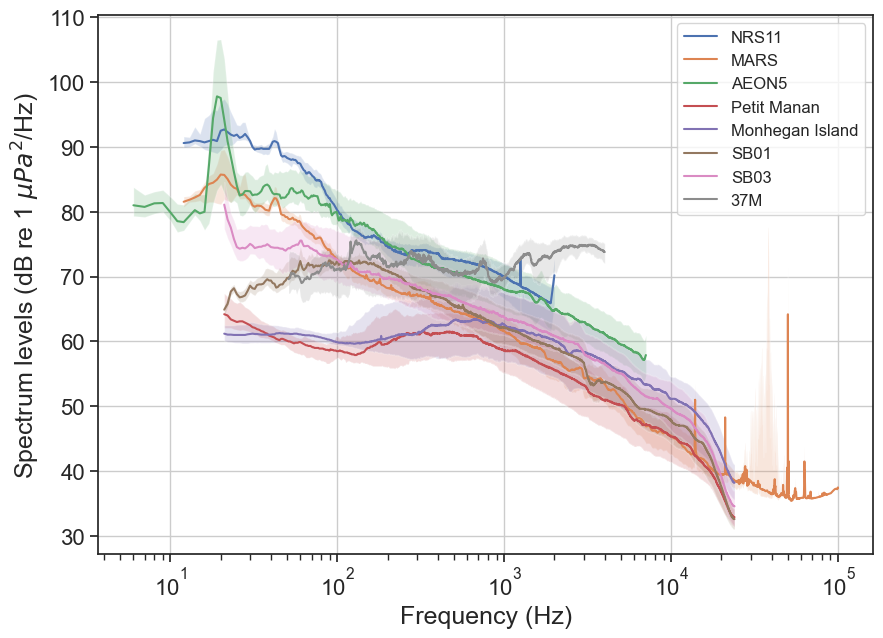

In [28]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

percentiles = [25, 75]

fig, ax = plt.subplots(figsize=(10, 7))
pypam.plots.plot_spectrum_median(just_NRS11, 'psd', percentiles=percentiles,
                                      frequency_coord='frequency',
                                      log=True, save_path=None,
                                      ax=ax, show=False, time_coord='time',
                                      label='NRS11')

pypam.plots.plot_spectrum_median(just_MARS, 'psd', percentiles=percentiles,
                                      frequency_coord='frequency',
                                      log=True, save_path=None,
                                      ax=ax, show=False, time_coord='time',
                                      label='MARS')

pypam.plots.plot_spectrum_median(just_AEON5, 'psd', percentiles=percentiles,
                                      frequency_coord='frequency',
                                      log=True, save_path=None,
                                      ax=ax, show=False, time_coord='time',
                                      label='AEON5')

pypam.plots.plot_spectrum_median(just_PManan, 'psd', percentiles=percentiles,
                                      frequency_coord='frequency',
                                      log=True, save_path=None,
                                      ax=ax, show=False, time_coord='time',
                                      label='Petit Manan')

pypam.plots.plot_spectrum_median(just_Monh, 'psd', percentiles=percentiles,
                                      frequency_coord='frequency',
                                      log=True, save_path=None,
                                      ax=ax, show=False, time_coord='time',
                                      label='Monhegan Island')

pypam.plots.plot_spectrum_median(just_SB01, 'psd', percentiles=percentiles,
                                      frequency_coord='frequency',
                                      log=True, save_path=None,
                                      ax=ax, show=False, time_coord='time',
                                      label='SB01')

pypam.plots.plot_spectrum_median(just_SB03, 'psd', percentiles=percentiles,
                                      frequency_coord='frequency',
                                      log=True, save_path=None,
                                      ax=ax, show=False, time_coord='time',
                                      label='SB03')

pypam.plots.plot_spectrum_median(just_ESONS, 'psd', percentiles=percentiles,
                                  frequency_coord='frequency',
                                  log=True, save_path=None,
                                  ax=ax, show=False, time_coord='time',
                                  label='37M')

# Set face color to white
ax.set_facecolor('white')

# Add labels and title
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('Spectrum levels (dB re 1 $\mu$$Pa^2$/Hz)', fontsize=18)
ax.set_title('')

# Set the font size of x-tick labels
ax.tick_params(axis='x', labelsize=16)

# Set the font size of y-tick labels (optional)
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)

plt.legend(fontsize=12)

# Show the plot
plt.show()

# Save the plot
fig.savefig(output_path+ '/SoundCoopPaper-CaseStudy2.png') # save as png